Loading pre-processed data from result\processed_fingerprints_ext.csv...
Pre-processed data loaded: 72478 fingerprints.
Preparing features (X) and labels (y)...
Splitting data into training and test sets (70/30 split)...
  Training set size: 50734 samples (20 features)
  Test set size: 21744 samples
Applying StandardScaler to features...
Scaling complete.

--- Hyperparameter Tuning for MLP with GridSearchCV ---
Searching parameter grid: {'hidden_layer_sizes': [(50,), (100,), (50, 30), (100, 50)], 'activation': ['relu', 'tanh'], 'solver': ['adam'], 'alpha': [0.0001, 0.001, 0.01], 'learning_rate_init': [0.001, 0.01]}
Using 3-fold cross-validation.
Fitting 3 folds for each of 48 candidates, totalling 144 fits
GridSearchCV finished in 254.36 seconds.
Best parameters found: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.001, 'solver': 'adam'}
Best cross-validation score (Negative MSE): -0.0000
--- End of GridSearchCV ---

Predicting locations

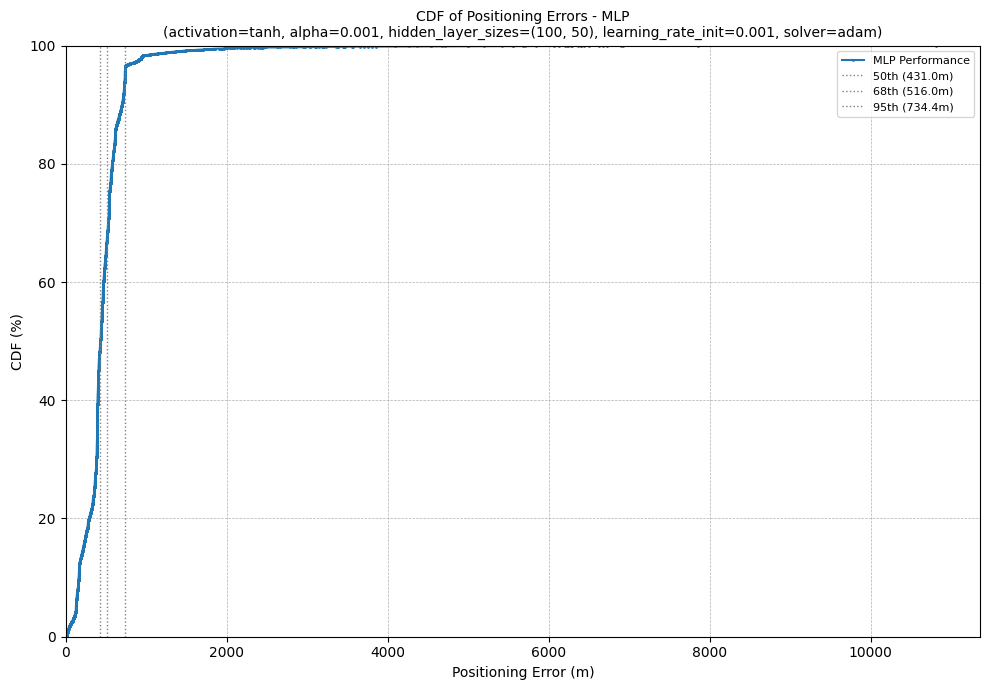

Script finished.


In [ ]:
# Imports at the top
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.neighbors import KNeighborsRegressor # Keep for KNN option
from sklearn.neural_network import MLPRegressor # Import MLP
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor # Needed for LGBM
import lightgbm as lgb # Keep for LGBM option
import geopy.distance
import os
import time
import matplotlib.pyplot as plt
import traceback

# --- User Configuration ---

# File Paths
RAW_DATA_FILE = 'dataset/5GDL.csv'
RESULTS_DIR = 'result'
PROCESSED_DATA_FILE = os.path.join(RESULTS_DIR, 'processed_fingerprints_ext.csv')

# Define the known unique PCIs based on your analysis/list
UNIQUE_PCIS = sorted([3, 13, 23, 30, 40, 48, 59, 68, 76])

# Default Values for Missing Signals/Data
NO_SIGNAL_RSRP_DBM = -155.0
NO_SIGNAL_RSRQ_DB = -40.0
DEFAULT_SINR_DB = -19.0
DEFAULT_TA = 0.0

# --- Fingerprint Features ---
FEATURE_COLS_RSRP = [f'RSRP_PCI{pci}' for pci in UNIQUE_PCIS]
FEATURE_COLS_RSRQ = [f'RSRQ_PCI{pci}' for pci in UNIQUE_PCIS]
FEATURE_COLS_OTHER = ['SINR_Serving', 'TA_Serving']
ALL_FEATURE_COLS = FEATURE_COLS_RSRP + FEATURE_COLS_RSRQ + FEATURE_COLS_OTHER
LABEL_COLS = ['Latitude', 'Longitude']

# --- Model & Tuning Configuration ---
MODEL_TYPE = 'KNN'       # Options: 'MLP', 'LGBM', 'KNN'
USE_SCALING = True       # Scaling is HIGHLY recommended for MLP & KNN
REPROCESS_DATA = False   # Set to True if raw data changed or first run
USE_GRID_SEARCH = True   # Set to True to find optimal params, False to use predefined below

# --- KNN Specific Parameters ---
DEFAULT_KNN_K_NEIGHBORS = 9
DEFAULT_KNN_WEIGHTS = 'distance'
DEFAULT_KNN_METRIC = 'manhattan'
KNN_GRIDSEARCH_PARAM_GRID = {
    'n_neighbors': list(range(3, 16, 2)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# --- LightGBM Specific Parameters ---
DEFAULT_LGBM_PARAMS = {
    'objective': 'regression_l2', 'metric': 'rmse', 'n_estimators': 500,
    'learning_rate': 0.05, 'num_leaves': 31, 'max_depth': -1,
    'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 1,
    'verbose': -1, 'n_jobs': -1, 'seed': 42
}
LGBM_GRIDSEARCH_PARAM_GRID = {
    'estimator__n_estimators': [200, 500, 1000],
    'estimator__learning_rate': [0.02, 0.05, 0.1],
    'estimator__num_leaves': [20, 31, 45],
}

# --- MLP Specific Parameters ---
# Used if MODEL_TYPE='MLP' and USE_GRID_SEARCH=False
DEFAULT_MLP_PARAMS = {
    'hidden_layer_sizes': (100, 50), # Example: 2 hidden layers
    'activation': 'relu',
    'solver': 'adam',
    'alpha': 0.0001,              # L2 regularization
    'batch_size': 'auto',
    'learning_rate': 'adaptive', # Relevant for solver='sgd' or 'adam'
    'learning_rate_init': 0.001,
    'max_iter': 500,              # Max training epochs
    'shuffle': True,
    'random_state': 42,
    'tol': 1e-4,
    'verbose': False,             # Set to True for convergence info
    'early_stopping': True,       # Recommended to prevent overfitting
    'validation_fraction': 0.1,   # Data fraction for early stopping
    'n_iter_no_change': 10        # Patience for early stopping
}

# Used if MODEL_TYPE='MLP' and USE_GRID_SEARCH=True
# Note: Tuning MLP can be computationally very expensive! Start small.
MLP_GRIDSEARCH_PARAM_GRID = {
    'hidden_layer_sizes': [(50,), (100,), (50, 30), (100, 50)], # Try different architectures
    'activation': ['relu', 'tanh'],
    'solver': ['adam'], # Adam is often a good default
    'alpha': [0.0001, 0.001, 0.01], # Regularization strength
    'learning_rate_init': [0.001, 0.01],
}

# General GridSearchCV Settings
GRIDSEARCH_CV_FOLDS = 3 # 5-fold can be very slow for MLP/LGBM, start with 3

# --- Ensure Results Directory Exists ---
os.makedirs(RESULTS_DIR, exist_ok=True)

# --- Functions (process_raw_data, calculate_errors - keep as before) ---
# process_raw_data definition... (Assuming it's the same as in the previous version)
def process_raw_data(df_raw, unique_pcis, no_signal_rsrp, no_signal_rsrq, default_sinr, default_ta):
    """Processes the raw UE data into a structured fingerprint DataFrame."""
    print("Processing raw data into fingerprints (including RSRQ, SINR)...")
    start_time = time.time()
    processed_data = []

    # --- Verify these column names match your CSV ---
    SERVING_PCI_COL = 'NR_UE_PCI_0'
    SERVING_RSRP_COL = 'NR_UE_RSRP_0'
    SERVING_RSRQ_COL = 'NR_UE_RSRQ_0'
    SERVING_SINR_COL = 'NR_UE_SINR_0'
    SERVING_TA_COL = 'NR_UE_Timing_Advance'
    NEIGHBOR_PCI_COLS = [f'NR_UE_Nbr_PCI_{i}' for i in range(5)] # Assuming max 5 neighbors
    NEIGHBOR_RSRP_COLS = [f'NR_UE_Nbr_RSRP_{i}' for i in range(5)]
    NEIGHBOR_RSRQ_COLS = [f'NR_UE_Nbr_RSRQ_{i}' for i in range(5)]
    # ---

    # Check for essential columns needed for processing
    essential_cols = LABEL_COLS + [SERVING_PCI_COL, SERVING_RSRP_COL] # TA is often missing
    optional_cols = [SERVING_RSRQ_COL, SERVING_SINR_COL, SERVING_TA_COL] + NEIGHBOR_PCI_COLS + NEIGHBOR_RSRP_COLS + NEIGHBOR_RSRQ_COLS

    missing_essential = [col for col in essential_cols if col not in df_raw.columns]
    if missing_essential:
        print(f"FATAL ERROR: Essential columns missing from raw data: {missing_essential}")
        return None # Indicate failure

    print(f"Found columns: {df_raw.columns.tolist()}") # Debugging info

    row_count = len(df_raw)
    print_interval = max(1, row_count // 10) # Print progress roughly 10 times

    for index, row in df_raw.iterrows():
        # Initialize fingerprint with default values
        fingerprint = {f'RSRP_PCI{pci}': no_signal_rsrp for pci in unique_pcis}
        fingerprint.update({f'RSRQ_PCI{pci}': no_signal_rsrq for pci in unique_pcis})
        fingerprint['TA_Serving'] = default_ta
        fingerprint['SINR_Serving'] = default_sinr
        fingerprint['Latitude'] = row['Latitude']
        fingerprint['Longitude'] = row['Longitude']

        # --- Serving Cell ---
        try:
            serving_pci_val = row.get(SERVING_PCI_COL)
            serving_rsrp_val = row.get(SERVING_RSRP_COL)
            serving_rsrq_val = row.get(SERVING_RSRQ_COL) # Optional
            serving_sinr_val = row.get(SERVING_SINR_COL) # Optional

            if pd.notna(serving_pci_val):
                serving_pci = int(serving_pci_val)
                if serving_pci in unique_pcis:
                    if pd.notna(serving_rsrp_val):
                        fingerprint[f'RSRP_PCI{serving_pci}'] = float(serving_rsrp_val)
                    if pd.notna(serving_rsrq_val):
                        fingerprint[f'RSRQ_PCI{serving_pci}'] = float(serving_rsrq_val)

            if pd.notna(serving_sinr_val):
                 fingerprint['SINR_Serving'] = float(serving_sinr_val)

        except (ValueError, TypeError) as e:
             # print(f"Warning: Data conversion error in serving cell processing at index {index}: {e}")
             pass

        # --- Neighbor Cells ---
        for i in range(len(NEIGHBOR_PCI_COLS)):
             try:
                 nbr_pci_col = NEIGHBOR_PCI_COLS[i]
                 nbr_rsrp_col = NEIGHBOR_RSRP_COLS[i]
                 nbr_rsrq_col = NEIGHBOR_RSRQ_COLS[i]

                 # Use .get() with default None for safer access
                 nbr_pci_val = row.get(nbr_pci_col)
                 nbr_rsrp_val = row.get(nbr_rsrp_col)
                 nbr_rsrq_val = row.get(nbr_rsrq_col)

                 if pd.notna(nbr_pci_val):
                     nbr_pci = int(nbr_pci_val)
                     if nbr_pci in unique_pcis:
                         if pd.notna(nbr_rsrp_val):
                             fingerprint[f'RSRP_PCI{nbr_pci}'] = float(nbr_rsrp_val)
                         if pd.notna(nbr_rsrq_val):
                             fingerprint[f'RSRQ_PCI{nbr_pci}'] = float(nbr_rsrq_val)

             except (ValueError, TypeError) as e:
                 # print(f"Warning: Data conversion error in neighbor cell {i} processing at index {index}: {e}")
                 pass

        # --- Timing Advance ---
        try:
            ta_val = row.get(SERVING_TA_COL) # Optional
            if pd.notna(ta_val):
                fingerprint['TA_Serving'] = float(ta_val)
        except (ValueError, TypeError) as e:
            # print(f"Warning: Data conversion error in TA processing at index {index}: {e}")
            pass

        processed_data.append(fingerprint)

        if (index + 1) % print_interval == 0 or (index + 1) == row_count:
            print(f"  Processed {index + 1}/{row_count} rows...")

    elapsed_time = time.time() - start_time
    print(f"Data processing finished in {elapsed_time:.2f} seconds.")
    return pd.DataFrame(processed_data)

# calculate_errors definition... (Assuming it's the same as in the previous version)
def calculate_errors(y_true_df, y_pred_array):
    """Calculates positioning errors and returns errors list and details DataFrame."""
    print("Calculating positioning errors...")
    errors = []
    error_details = []
    invalid_preds = 0

    if len(y_true_df) != len(y_pred_array):
        print("Error: Mismatch between number of true labels and predictions.")
        return np.array([]), pd.DataFrame()

    for i in range(len(y_true_df)):
        true_lat = y_true_df.iloc[i]['Latitude']
        true_lon = y_true_df.iloc[i]['Longitude']
        pred_lat = y_pred_array[i][0]
        pred_lon = y_pred_array[i][1]

        # Basic check for valid coordinate ranges
        if -90 <= pred_lat <= 90 and -180 <= pred_lon <= 180:
            try:
                # Use geodesic distance (more accurate for geographic coords)
                distance = geopy.distance.geodesic((true_lat, true_lon), (pred_lat, pred_lon)).meters
                errors.append(distance)
                error_details.append({
                    'true_lat': true_lat,
                    'true_lon': true_lon,
                    'pred_lat': pred_lat,
                    'pred_lon': pred_lon,
                    'error_m': distance
                })
            except ValueError as e:
                print(f"Warning: geopy error for point {i} (True: {true_lat},{true_lon}, Pred: {pred_lat},{pred_lon}): {e}. Skipping.")
                invalid_preds += 1
        else:
            print(f"Warning: Invalid predicted coordinates ({pred_lat:.4f}, {pred_lon:.4f}) for test point {i}. Skipping.")
            error_details.append({
                'true_lat': true_lat,
                'true_lon': true_lon,
                'pred_lat': pred_lat, # Store invalid prediction
                'pred_lon': pred_lon,
                'error_m': np.nan # Mark error as NaN
            })
            invalid_preds += 1

    print(f"Finished calculating errors. Skipped {invalid_preds} invalid predictions.")
    return np.array(errors), pd.DataFrame(error_details)

# --- Main Script ---

# 1. Load and Process Data
# ... (Keep the same robust loading/processing logic) ...
processed_df = None
if REPROCESS_DATA or not os.path.exists(PROCESSED_DATA_FILE):
    try:
        print(f"Loading raw data from {RAW_DATA_FILE}...")
        df_raw = pd.read_csv(RAW_DATA_FILE)
        print(f"Raw data loaded: {df_raw.shape[0]} rows, {df_raw.shape[1]} columns.")
        initial_rows = len(df_raw)
        df_raw = df_raw.dropna(subset=LABEL_COLS)
        if len(df_raw) < initial_rows:
            print(f"Dropped {initial_rows - len(df_raw)} rows with missing Lat/Lon.")
        if df_raw.empty:
             print("Error: No valid rows remaining after dropping missing Lat/Lon.")
             exit()
        processed_df = process_raw_data(df_raw, UNIQUE_PCIS, NO_SIGNAL_RSRP_DBM, NO_SIGNAL_RSRQ_DB, DEFAULT_SINR_DB, DEFAULT_TA)
        if processed_df is None or processed_df.empty:
             print("Error: Data processing failed or resulted in an empty DataFrame.")
             exit()
        print(f"Saving processed data ({len(processed_df)} fingerprints) to {PROCESSED_DATA_FILE}...")
        processed_df.to_csv(PROCESSED_DATA_FILE, index=False)
        print("Processed data saved.")
    except FileNotFoundError:
        print(f"FATAL ERROR: Raw data file not found at {RAW_DATA_FILE}")
        exit()
    except Exception as e:
        print(f"FATAL ERROR during data loading/processing: {e}")
        traceback.print_exc()
        exit()
else:
    print(f"Loading pre-processed data from {PROCESSED_DATA_FILE}...")
    try:
        processed_df = pd.read_csv(PROCESSED_DATA_FILE)
        print(f"Pre-processed data loaded: {len(processed_df)} fingerprints.")
    except FileNotFoundError:
        print(f"FATAL ERROR: Processed data file not found at {PROCESSED_DATA_FILE}. Set REPROCESS_DATA=True.")
        exit()
    except Exception as e:
        print(f"FATAL ERROR loading processed data: {e}")
        exit()

if processed_df is None or processed_df.empty:
    print("FATAL ERROR: No data available for modeling.")
    exit()

# 2. Prepare Features (X) and Labels (y)
# ... (Keep the same logic) ...
print("Preparing features (X) and labels (y)...")
try:
    X = processed_df[ALL_FEATURE_COLS]
    y = processed_df[LABEL_COLS]
except KeyError as e:
    print(f"FATAL ERROR: Missing expected feature/label columns in processed data: {e}")
    print(f"Available columns: {processed_df.columns.tolist()}")
    exit()

# Check for rows with only default values
# ... (Keep the same check) ...
rsrp_defaults = (X[FEATURE_COLS_RSRP] == NO_SIGNAL_RSRP_DBM).all(axis=1)
rsrq_defaults = (X[FEATURE_COLS_RSRQ] == NO_SIGNAL_RSRQ_DB).all(axis=1)
other_defaults = True
if 'SINR_Serving' in X: other_defaults &= (X['SINR_Serving'] == DEFAULT_SINR_DB)
if 'TA_Serving' in X: other_defaults &= (X['TA_Serving'] == DEFAULT_TA)
if (rsrp_defaults & rsrq_defaults & other_defaults).any():
     print("Warning: Some rows seem to contain only default feature values across all signal types.")

# 3. Split Data into Training and Test Sets
# ... (Keep the same logic) ...
print("Splitting data into training and test sets (70/30 split)...")
if len(X) < 2:
    print("FATAL ERROR: Not enough data samples to create train/test splits.")
    exit()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"  Training set size: {len(X_train)} samples ({X_train.shape[1]} features)")
print(f"  Test set size: {len(X_test)} samples")
if len(X_train) == 0 or len(X_test) == 0:
    print("FATAL ERROR: Train or test split resulted in zero samples.")
    exit()

# 4. Feature Scaling (Conditional)
scaler = None
X_train_scaled = X_train.values
X_test_scaled = X_test.values
if USE_SCALING:
    print("Applying StandardScaler to features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("Scaling complete.")
else:
    print("Feature scaling is disabled.")
    if MODEL_TYPE in ['KNN', 'MLP']:
        print(f"WARNING: Feature scaling is highly recommended for {MODEL_TYPE} but is disabled!")


# 5. Model Training / Tuning - ADDED MLP OPTION
model = None
best_params = {}
model_name = ""

if MODEL_TYPE == 'MLP':
    model_name = "MLP"
    if USE_GRID_SEARCH:
        print(f"\n--- Hyperparameter Tuning for {model_name} with GridSearchCV ---")
        if not USE_SCALING:
             print("WARNING: Running MLP GridSearch without scaling. Results may be suboptimal.")
        start_time_grid = time.time()

        # Base MLP model - enable early stopping for efficiency during grid search
        mlp_base = MLPRegressor(random_state=42, early_stopping=True, validation_fraction=0.1, n_iter_no_change=10)

        print(f"Searching parameter grid: {MLP_GRIDSEARCH_PARAM_GRID}")
        print(f"Using {GRIDSEARCH_CV_FOLDS}-fold cross-validation.")
        grid_search = GridSearchCV(estimator=mlp_base,
                                   param_grid=MLP_GRIDSEARCH_PARAM_GRID,
                                   cv=GRIDSEARCH_CV_FOLDS,
                                   scoring='neg_mean_squared_error',
                                   refit=True,
                                   verbose=2,
                                   n_jobs=-1) # Use multiple cores for grid search if possible

        # Fit GridSearchCV on the TRAINING data (scaled if USE_SCALING is True)
        # MLPRegressor handles multi-output directly
        grid_search.fit(X_train_scaled, y_train)

        elapsed_time_grid = time.time() - start_time_grid
        print(f"GridSearchCV finished in {elapsed_time_grid:.2f} seconds.")

        model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"Best parameters found: {best_params}")
        # Re-train final model with potentially more iterations if early stopping was aggressive
        # This is optional but sometimes done
        # print("Retraining best MLP model with full iterations...")
        # final_mlp_params = grid_search.best_params_.copy()
        # final_mlp_params['early_stopping'] = False # Turn off early stopping for final train
        # final_mlp_params['max_iter'] = DEFAULT_MLP_PARAMS.get('max_iter', 500) # Use default max_iter
        # model = MLPRegressor(random_state=42, **final_mlp_params)
        # model.fit(X_train_scaled, y_train)
        print(f"Best cross-validation score (Negative MSE): {grid_search.best_score_:.4f}")
        print("--- End of GridSearchCV ---")

    else:
        print(f"\n--- Training {model_name} with Predefined Parameters ---")
        if not USE_SCALING:
             print("WARNING: Training MLP without scaling. Results may be suboptimal.")
        start_time_train = time.time()
        print(f"Using parameters: {DEFAULT_MLP_PARAMS}")

        model = MLPRegressor(**DEFAULT_MLP_PARAMS) # Use the defaults
        model.fit(X_train_scaled, y_train) # Train the model directly

        best_params = DEFAULT_MLP_PARAMS # Store defaults for reporting
        elapsed_time_train = time.time() - start_time_train
        print(f"Manual {model_name} training finished in {elapsed_time_train:.2f} seconds.")
        print("--- End of Manual Training ---")


elif MODEL_TYPE == 'LGBM':
    # --- LGBM Training Logic (from previous version) ---
    model_name = "LightGBM"
    base_lgbm = lgb.LGBMRegressor(**DEFAULT_LGBM_PARAMS)
    multi_output_lgbm = MultiOutputRegressor(base_lgbm, n_jobs=-1)

    if USE_GRID_SEARCH:
        print(f"\n--- Hyperparameter Tuning for {model_name} with GridSearchCV ---")
        start_time_grid = time.time()
        print(f"Searching parameter grid: {LGBM_GRIDSEARCH_PARAM_GRID}")
        print(f"Using {GRIDSEARCH_CV_FOLDS}-fold cross-validation.")
        grid_search = GridSearchCV(estimator=multi_output_lgbm, param_grid=LGBM_GRIDSEARCH_PARAM_GRID,
                                   cv=GRIDSEARCH_CV_FOLDS, scoring='neg_mean_squared_error',
                                   refit=True, verbose=2, n_jobs=1)
        grid_search.fit(X_train_scaled, y_train)
        elapsed_time_grid = time.time() - start_time_grid
        print(f"GridSearchCV finished in {elapsed_time_grid:.2f} seconds.")
        model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"Best parameters found: {best_params}")
        print(f"Best cross-validation score (Negative MSE): {grid_search.best_score_:.4f}")
        print("--- End of GridSearchCV ---")
    else:
        print(f"\n--- Training {model_name} with Predefined Parameters ---")
        start_time_train = time.time()
        print(f"Using parameters: {DEFAULT_LGBM_PARAMS}")
        model = multi_output_lgbm
        model.fit(X_train_scaled, y_train)
        best_params = DEFAULT_LGBM_PARAMS
        elapsed_time_train = time.time() - start_time_train
        print(f"Manual {model_name} training finished in {elapsed_time_train:.2f} seconds.")
        print("--- End of Manual Training ---")

elif MODEL_TYPE == 'KNN':
    # --- KNN Training Logic (from previous version) ---
    model_name = "KNN"
    from sklearn.neighbors import KNeighborsRegressor # Import locally if needed
    if USE_GRID_SEARCH:
        print("\n--- Hyperparameter Tuning for KNN with GridSearchCV ---")
        if not USE_SCALING:
             print("WARNING: Running KNN GridSearch without scaling. Results may be suboptimal.")
        start_time_grid = time.time()
        knn_base = KNeighborsRegressor(n_jobs=-1)
        print(f"Searching parameter grid: {KNN_GRIDSEARCH_PARAM_GRID}")
        print(f"Using {GRIDSEARCH_CV_FOLDS}-fold cross-validation.")
        grid_search = GridSearchCV(knn_base, KNN_GRIDSEARCH_PARAM_GRID, cv=GRIDSEARCH_CV_FOLDS,
                                   scoring='neg_mean_squared_error', refit=True, verbose=1, n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)
        elapsed_time_grid = time.time() - start_time_grid
        print(f"GridSearchCV finished in {elapsed_time_grid:.2f} seconds.")
        model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"Best parameters found: {best_params}")
        print(f"Best cross-validation score (Negative MSE): {grid_search.best_score_:.4f}")
        print("--- End of GridSearchCV ---")
    else:
        print("\n--- Training KNN with Predefined Parameters ---")
        if not USE_SCALING:
             print("WARNING: Training KNN without scaling. Results may be suboptimal.")
        start_time_train = time.time()
        best_params = {
            'n_neighbors': DEFAULT_KNN_K_NEIGHBORS, 'weights': DEFAULT_KNN_WEIGHTS, 'metric': DEFAULT_KNN_METRIC
        }
        print(f"Using parameters: k={best_params['n_neighbors']}, weights='{best_params['weights']}', metric='{best_params['metric']}'")
        model = KNeighborsRegressor(**best_params, n_jobs=-1)
        model.fit(X_train_scaled, y_train)
        elapsed_time_train = time.time() - start_time_train
        print(f"Manual KNN training finished in {elapsed_time_train:.2f} seconds.")
        print("--- End of Manual Training ---")

else:
    print(f"FATAL ERROR: Unknown MODEL_TYPE '{MODEL_TYPE}' specified.")
    exit()


# --- Define Final Output Filename (using generic logic) ---
# Function to safely format parameters for filename
def format_params_for_filename(params):
    items = []
    for k, v in params.items():
        key_name = k.split('__')[-1] # Handle 'estimator__' prefix
        # Simplify common structures
        if isinstance(v, tuple):
            val_str = "x".join(map(str, v)) # e.g., (100, 50) -> "100x50"
        else:
            val_str = str(v)
        items.append(f"{key_name}_{val_str}")
    return "_".join(items).replace("'", "").replace(" ", "").replace(",", "")

params_str = format_params_for_filename(best_params)
# Limit filename length
filename_base = f'{model_name}_pos_errors_{params_str}'
max_len = 200 # Max length for base filename part
if len(filename_base) > max_len:
    filename_base = filename_base[:max_len]

ERROR_OUTPUT_FILE = os.path.join(RESULTS_DIR, f'{filename_base}.csv')
PLOT_OUTPUT_FILE = ERROR_OUTPUT_FILE.replace('.csv', '_cdf.png')


# 6. Predict on Test Set
# ... (Keep existing logic, uses the trained 'model') ...
print(f"\nPredicting locations for the test set using {model_name}...")
start_time_pred = time.time()
if model is None:
     print(f"FATAL ERROR: {model_name} model was not trained.")
     exit()
y_pred = model.predict(X_test_scaled)
elapsed_time_pred = time.time() - start_time_pred
print(f"Prediction finished in {elapsed_time_pred:.2f} seconds.")


# 7. Calculate Errors and Save Details
# ... (Keep existing logic) ...
valid_errors, error_details_df = calculate_errors(y_test, y_pred)
if not error_details_df.empty:
    print(f"\nSaving detailed error results to {ERROR_OUTPUT_FILE}...")
    try:
        error_details_df.to_csv(ERROR_OUTPUT_FILE, index=False, float_format='%.6f')
        print("Error details saved successfully.")
    except Exception as e:
        print(f"Error saving error details CSV: {e}")
else:
    print("\nNo error details to save.")


# 8. Report Aggregate Performance Metrics
# ... (Keep existing logic, uses model_name and best_params) ...
if len(valid_errors) > 0:
    mean_error = np.mean(valid_errors)
    median_error = np.median(valid_errors)
    std_dev_error = np.std(valid_errors)
    rmse_dist = np.sqrt(np.mean(np.square(valid_errors))) # RMSE on distance errors

    print(f"\n--- Positioning Performance ({model_name}) ---")
    # Pretty print best_params, handling potentially long tuples etc.
    params_report_str = ", ".join(f"{k.split('__')[-1]}={v}" for k, v in best_params.items())
    print(f"Model Parameters Used: {params_report_str}")
    print(f"Number of Test Points Evaluated: {len(valid_errors)} (out of {len(y_test)})")
    print(f"Mean Error:      {mean_error:.2f} m")
    print(f"Median Error:    {median_error:.2f} m (50th Percentile)")
    print(f"Std Deviation:   {std_dev_error:.2f} m")
    print(f"RMSE (distance): {rmse_dist:.2f} m")

    # Percentiles
    percentiles_to_calc = [ 20, 40, 50, 68, 80, 90, 95]
    percentile_values = np.percentile(valid_errors, percentiles_to_calc)
    print("\nError Percentiles (CDF):")
    for p, v in zip(percentiles_to_calc, percentile_values):
        print(f"  {p}th Percentile:  {v:.2f} m")
    print("-----------------------------\n")

    # Generate and Save CDF Plot
    print(f"Generating CDF plot...")
    try:
        sorted_errors = np.sort(valid_errors)
        cdf = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
        plt.figure(figsize=(10, 7))
        plt.plot(sorted_errors, cdf * 100, marker='.', linestyle='-', markersize=2, label=f'{model_name} Performance')
        plt.xlabel("Positioning Error (m)")
        plt.ylabel("CDF (%)")
        # Use shorter title params string
        title_params = ", ".join(f"{k.split('__')[-1]}={v}" for k, v in best_params.items() if not isinstance(v, dict)) # Avoid printing nested dicts
        plt.title(f"CDF of Positioning Errors - {model_name}\n({title_params})", fontsize=10)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.ylim(0, 100)
        plt.xlim(left=0)
        for p in [50, 68, 95]:
            val = np.percentile(valid_errors, p)
            plt.axvline(val, color='grey', linestyle=':', linewidth=1, label=f'{p}th ({val:.1f}m)')
        plt.legend(fontsize=8)
        plt.tight_layout()
        plt.savefig(PLOT_OUTPUT_FILE)
        print(f"CDF plot saved to {PLOT_OUTPUT_FILE}")
        plt.show()
    except Exception as e:
        print(f"Error generating or saving plot: {e}")
        traceback.print_exc()

else:
    print("\n--- Positioning Performance ---")
    print("No valid error measurements were calculated. Cannot report performance metrics.")
    print("-----------------------------\n")

print("Script finished.")

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.neighbors import KNeighborsRegressor # Keep if you want to switch back easily
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor # Needed for LGBM multi-target regression
import lightgbm as lgb # Import LightGBM
import geopy.distance
import os
import time
import matplotlib.pyplot as plt
import traceback # For detailed error prints

# --- User Configuration ---

# File Paths
RAW_DATA_FILE = 'dataset/5GDL.csv'
RESULTS_DIR = 'result' # Define results directory
PROCESSED_DATA_FILE = os.path.join(RESULTS_DIR, 'processed_fingerprints_ext.csv')

# Define the known unique PCIs based on your analysis/list
UNIQUE_PCIS = sorted([3, 13, 23, 30, 40, 48, 59, 68, 76]) # <-- !!! VERIFY this list is complete

# Default Values for Missing Signals/Data
NO_SIGNAL_RSRP_DBM = -155.0
NO_SIGNAL_RSRQ_DB = -40.0
DEFAULT_SINR_DB = -19.0 # Ensure float
DEFAULT_TA = 0.0         # Ensure float

# --- Fingerprint Features ---
FEATURE_COLS_RSRP = [f'RSRP_PCI{pci}' for pci in UNIQUE_PCIS]
FEATURE_COLS_RSRQ = [f'RSRQ_PCI{pci}' for pci in UNIQUE_PCIS]
FEATURE_COLS_OTHER = ['SINR_Serving', 'TA_Serving']
ALL_FEATURE_COLS = FEATURE_COLS_RSRP + FEATURE_COLS_RSRQ + FEATURE_COLS_OTHER
LABEL_COLS = ['Latitude', 'Longitude']

# --- Model & Tuning Configuration ---
MODEL_TYPE = 'LGBM'      # Options: 'LGBM', 'KNN'
USE_SCALING = True       # Scaling is generally recommended, less critical for LGBM but doesn't hurt
REPROCESS_DATA = False   # Set to True if raw data changed or first run
USE_GRID_SEARCH = True   # Set to True to find optimal params, False to use predefined below

# --- KNN Specific Parameters (Used if MODEL_TYPE='KNN' and USE_GRID_SEARCH=False) ---
DEFAULT_KNN_K_NEIGHBORS = 9
DEFAULT_KNN_WEIGHTS = 'distance'
DEFAULT_KNN_METRIC = 'manhattan'
KNN_GRIDSEARCH_PARAM_GRID = {
    'n_neighbors': list(range(3, 16, 2)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# --- LightGBM Specific Parameters ---
# Used if MODEL_TYPE='LGBM' and USE_GRID_SEARCH=False
DEFAULT_LGBM_PARAMS = {
    'objective': 'regression_l2', # L2 loss for regression
    'metric': 'rmse',             # Root Mean Squared Error metric
    'n_estimators': 500,          # Number of boosting rounds (trees)
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,              # No limit
    'feature_fraction': 0.8,      # Randomly select 80% of features per tree
    'bagging_fraction': 0.8,      # Randomly select 80% of data per tree (if bagging_freq > 0)
    'bagging_freq': 1,            # Perform bagging every iteration
    'verbose': -1,                # Suppress verbose output
    'n_jobs': -1,                 # Use all available cores
    'seed': 42                    # For reproducibility
}

# Used if MODEL_TYPE='LGBM' and USE_GRID_SEARCH=True
# IMPORTANT: Prefix parameters with 'estimator__' for MultiOutputRegressor
LGBM_GRIDSEARCH_PARAM_GRID = {
    'estimator__n_estimators': [200, 500, 1000],
    'estimator__learning_rate': [0.02, 0.05, 0.1],
    'estimator__num_leaves': [20, 31, 45],
    # Add other parameters like 'max_depth', 'feature_fraction' if needed
    # 'estimator__max_depth': [5, 7, -1],
    # 'estimator__feature_fraction': [0.7, 0.8, 0.9],
}

# General GridSearchCV Settings
GRIDSEARCH_CV_FOLDS = 3 # 5-fold can be slow for LGBM, start with 3

# --- Ensure Results Directory Exists ---
os.makedirs(RESULTS_DIR, exist_ok=True)

# --- Functions (process_raw_data, calculate_errors - keep as before) ---
def process_raw_data(df_raw, unique_pcis, no_signal_rsrp, no_signal_rsrq, default_sinr, default_ta):
    """Processes the raw UE data into a structured fingerprint DataFrame."""
    print("Processing raw data into fingerprints (including RSRQ, SINR)...")
    start_time = time.time()
    processed_data = []

    # --- Verify these column names match your CSV ---
    SERVING_PCI_COL = 'NR_UE_PCI_0'
    SERVING_RSRP_COL = 'NR_UE_RSRP_0'
    SERVING_RSRQ_COL = 'NR_UE_RSRQ_0'
    SERVING_SINR_COL = 'NR_UE_SINR_0'
    SERVING_TA_COL = 'NR_UE_Timing_Advance'
    NEIGHBOR_PCI_COLS = [f'NR_UE_Nbr_PCI_{i}' for i in range(5)] # Assuming max 5 neighbors
    NEIGHBOR_RSRP_COLS = [f'NR_UE_Nbr_RSRP_{i}' for i in range(5)]
    NEIGHBOR_RSRQ_COLS = [f'NR_UE_Nbr_RSRQ_{i}' for i in range(5)]
    # ---

    # Check for essential columns needed for processing
    essential_cols = LABEL_COLS + [SERVING_PCI_COL, SERVING_RSRP_COL] # TA is often missing
    optional_cols = [SERVING_RSRQ_COL, SERVING_SINR_COL, SERVING_TA_COL] + NEIGHBOR_PCI_COLS + NEIGHBOR_RSRP_COLS + NEIGHBOR_RSRQ_COLS

    missing_essential = [col for col in essential_cols if col not in df_raw.columns]
    if missing_essential:
        print(f"FATAL ERROR: Essential columns missing from raw data: {missing_essential}")
        return None # Indicate failure

    print(f"Found columns: {df_raw.columns.tolist()}") # Debugging info

    row_count = len(df_raw)
    print_interval = max(1, row_count // 10) # Print progress roughly 10 times

    for index, row in df_raw.iterrows():
        # Initialize fingerprint with default values
        fingerprint = {f'RSRP_PCI{pci}': no_signal_rsrp for pci in unique_pcis}
        fingerprint.update({f'RSRQ_PCI{pci}': no_signal_rsrq for pci in unique_pcis})
        fingerprint['TA_Serving'] = default_ta
        fingerprint['SINR_Serving'] = default_sinr
        fingerprint['Latitude'] = row['Latitude']
        fingerprint['Longitude'] = row['Longitude']

        # --- Serving Cell ---
        try:
            serving_pci_val = row.get(SERVING_PCI_COL)
            serving_rsrp_val = row.get(SERVING_RSRP_COL)
            serving_rsrq_val = row.get(SERVING_RSRQ_COL) # Optional
            serving_sinr_val = row.get(SERVING_SINR_COL) # Optional

            if pd.notna(serving_pci_val):
                serving_pci = int(serving_pci_val)
                if serving_pci in unique_pcis:
                    if pd.notna(serving_rsrp_val):
                        fingerprint[f'RSRP_PCI{serving_pci}'] = float(serving_rsrp_val)
                    if pd.notna(serving_rsrq_val):
                        fingerprint[f'RSRQ_PCI{serving_pci}'] = float(serving_rsrq_val)

            if pd.notna(serving_sinr_val):
                 fingerprint['SINR_Serving'] = float(serving_sinr_val)

        except (ValueError, TypeError) as e:
             # print(f"Warning: Data conversion error in serving cell processing at index {index}: {e}")
             pass

        # --- Neighbor Cells ---
        for i in range(len(NEIGHBOR_PCI_COLS)):
             try:
                 nbr_pci_col = NEIGHBOR_PCI_COLS[i]
                 nbr_rsrp_col = NEIGHBOR_RSRP_COLS[i]
                 nbr_rsrq_col = NEIGHBOR_RSRQ_COLS[i]

                 # Use .get() with default None for safer access
                 nbr_pci_val = row.get(nbr_pci_col)
                 nbr_rsrp_val = row.get(nbr_rsrp_col)
                 nbr_rsrq_val = row.get(nbr_rsrq_col)

                 if pd.notna(nbr_pci_val):
                     nbr_pci = int(nbr_pci_val)
                     if nbr_pci in unique_pcis:
                         if pd.notna(nbr_rsrp_val):
                             fingerprint[f'RSRP_PCI{nbr_pci}'] = float(nbr_rsrp_val)
                         if pd.notna(nbr_rsrq_val):
                             fingerprint[f'RSRQ_PCI{nbr_pci}'] = float(nbr_rsrq_val)

             except (ValueError, TypeError) as e:
                 # print(f"Warning: Data conversion error in neighbor cell {i} processing at index {index}: {e}")
                 pass

        # --- Timing Advance ---
        try:
            ta_val = row.get(SERVING_TA_COL) # Optional
            if pd.notna(ta_val):
                fingerprint['TA_Serving'] = float(ta_val)
        except (ValueError, TypeError) as e:
            # print(f"Warning: Data conversion error in TA processing at index {index}: {e}")
            pass

        processed_data.append(fingerprint)

        if (index + 1) % print_interval == 0 or (index + 1) == row_count:
            print(f"  Processed {index + 1}/{row_count} rows...")

    elapsed_time = time.time() - start_time
    print(f"Data processing finished in {elapsed_time:.2f} seconds.")
    return pd.DataFrame(processed_data)

def calculate_errors(y_true_df, y_pred_array):
    """Calculates positioning errors and returns errors list and details DataFrame."""
    print("Calculating positioning errors...")
    errors = []
    error_details = []
    invalid_preds = 0

    if len(y_true_df) != len(y_pred_array):
        print("Error: Mismatch between number of true labels and predictions.")
        return np.array([]), pd.DataFrame()

    for i in range(len(y_true_df)):
        true_lat = y_true_df.iloc[i]['Latitude']
        true_lon = y_true_df.iloc[i]['Longitude']
        pred_lat = y_pred_array[i][0]
        pred_lon = y_pred_array[i][1]

        # Basic check for valid coordinate ranges
        if -90 <= pred_lat <= 90 and -180 <= pred_lon <= 180:
            try:
                # Use geodesic distance (more accurate for geographic coords)
                distance = geopy.distance.geodesic((true_lat, true_lon), (pred_lat, pred_lon)).meters
                errors.append(distance)
                error_details.append({
                    'true_lat': true_lat,
                    'true_lon': true_lon,
                    'pred_lat': pred_lat,
                    'pred_lon': pred_lon,
                    'error_m': distance
                })
            except ValueError as e:
                print(f"Warning: geopy error for point {i} (True: {true_lat},{true_lon}, Pred: {pred_lat},{pred_lon}): {e}. Skipping.")
                invalid_preds += 1
        else:
            print(f"Warning: Invalid predicted coordinates ({pred_lat:.4f}, {pred_lon:.4f}) for test point {i}. Skipping.")
            error_details.append({
                'true_lat': true_lat,
                'true_lon': true_lon,
                'pred_lat': pred_lat, # Store invalid prediction
                'pred_lon': pred_lon,
                'error_m': np.nan # Mark error as NaN
            })
            invalid_preds += 1

    print(f"Finished calculating errors. Skipped {invalid_preds} invalid predictions.")
    return np.array(errors), pd.DataFrame(error_details)

# --- Main Script ---

# 1. Load and Process Data
# ... (Keep the existing robust loading/processing logic from previous version) ...
processed_df = None
if REPROCESS_DATA or not os.path.exists(PROCESSED_DATA_FILE):
    try:
        print(f"Loading raw data from {RAW_DATA_FILE}...")
        df_raw = pd.read_csv(RAW_DATA_FILE)
        print(f"Raw data loaded: {df_raw.shape[0]} rows, {df_raw.shape[1]} columns.")

        initial_rows = len(df_raw)
        df_raw = df_raw.dropna(subset=LABEL_COLS)
        if len(df_raw) < initial_rows:
            print(f"Dropped {initial_rows - len(df_raw)} rows with missing Lat/Lon.")

        if df_raw.empty:
             print("Error: No valid rows remaining after dropping missing Lat/Lon.")
             exit()

        processed_df = process_raw_data(df_raw, UNIQUE_PCIS,
                                          NO_SIGNAL_RSRP_DBM,
                                          NO_SIGNAL_RSRQ_DB,
                                          DEFAULT_SINR_DB,
                                          DEFAULT_TA)
        if processed_df is None or processed_df.empty:
             print("Error: Data processing failed or resulted in an empty DataFrame.")
             exit()

        print(f"Saving processed data ({len(processed_df)} fingerprints) to {PROCESSED_DATA_FILE}...")
        processed_df.to_csv(PROCESSED_DATA_FILE, index=False)
        print("Processed data saved.")

    except FileNotFoundError:
        print(f"FATAL ERROR: Raw data file not found at {RAW_DATA_FILE}")
        exit()
    except Exception as e:
        print(f"FATAL ERROR during data loading/processing: {e}")
        traceback.print_exc()
        exit()
else:
    print(f"Loading pre-processed data from {PROCESSED_DATA_FILE}...")
    try:
        processed_df = pd.read_csv(PROCESSED_DATA_FILE)
        print(f"Pre-processed data loaded: {len(processed_df)} fingerprints.")
    except FileNotFoundError:
        print(f"FATAL ERROR: Processed data file not found at {PROCESSED_DATA_FILE}. Set REPROCESS_DATA=True.")
        exit()
    except Exception as e:
        print(f"FATAL ERROR loading processed data: {e}")
        exit()

if processed_df is None or processed_df.empty:
    print("FATAL ERROR: No data available for modeling.")
    exit()

# 2. Prepare Features (X) and Labels (y)
# ... (Keep the existing logic) ...
print("Preparing features (X) and labels (y)...")
try:
    X = processed_df[ALL_FEATURE_COLS]
    y = processed_df[LABEL_COLS]
except KeyError as e:
    print(f"FATAL ERROR: Missing expected feature/label columns in processed data: {e}")
    print(f"Available columns: {processed_df.columns.tolist()}")
    exit()

# Check for rows with only default values
# ... (Keep the existing check) ...
rsrp_defaults = (X[FEATURE_COLS_RSRP] == NO_SIGNAL_RSRP_DBM).all(axis=1)
rsrq_defaults = (X[FEATURE_COLS_RSRQ] == NO_SIGNAL_RSRQ_DB).all(axis=1)
other_defaults = True
if 'SINR_Serving' in X:
    other_defaults &= (X['SINR_Serving'] == DEFAULT_SINR_DB)
if 'TA_Serving' in X:
    other_defaults &= (X['TA_Serving'] == DEFAULT_TA)
if (rsrp_defaults & rsrq_defaults & other_defaults).any():
     print("Warning: Some rows seem to contain only default feature values across all signal types.")

# 3. Split Data into Training and Test Sets
# ... (Keep the existing logic) ...
print("Splitting data into training and test sets (70/30 split)...")
if len(X) < 2:
    print("FATAL ERROR: Not enough data samples to create train/test splits.")
    exit()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"  Training set size: {len(X_train)} samples ({X_train.shape[1]} features)")
print(f"  Test set size: {len(X_test)} samples")
if len(X_train) == 0 or len(X_test) == 0:
    print("FATAL ERROR: Train or test split resulted in zero samples.")
    exit()

# 4. Feature Scaling (Conditional)
# Renamed variables for clarity
scaler = None
X_train_scaled = X_train.values
X_test_scaled = X_test.values
if USE_SCALING:
    print("Applying StandardScaler to features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train) # Fit AND transform training data
    X_test_scaled = scaler.transform(X_test)       # Transform test data
    print("Scaling complete.")
else:
    print("Feature scaling is disabled.")


# 5. Model Training / Tuning - MODIFIED FOR MODEL_TYPE
model = None
best_params = {}
model_name = "" # For reporting

if MODEL_TYPE == 'LGBM':
    model_name = "LightGBM"
    base_lgbm = lgb.LGBMRegressor(**DEFAULT_LGBM_PARAMS) # Use defaults initially
    # Wrap with MultiOutputRegressor for Lat/Lon prediction
    multi_output_lgbm = MultiOutputRegressor(base_lgbm, n_jobs=-1) # Parallelize model fitting

    if USE_GRID_SEARCH:
        print(f"\n--- Hyperparameter Tuning for {model_name} with GridSearchCV ---")
        start_time_grid = time.time()

        print(f"Searching parameter grid: {LGBM_GRIDSEARCH_PARAM_GRID}")
        print(f"Using {GRIDSEARCH_CV_FOLDS}-fold cross-validation.")

        # Note: GridSearchCV with LGBM can be slow! Consider RandomizedSearchCV for larger grids.
        grid_search = GridSearchCV(estimator=multi_output_lgbm,
                                   param_grid=LGBM_GRIDSEARCH_PARAM_GRID,
                                   cv=GRIDSEARCH_CV_FOLDS,
                                   scoring='neg_mean_squared_error', # Lower error = better
                                   refit=True, # Retrains best model on full train set
                                   verbose=2, # Shows more progress
                                   n_jobs=1) # GridSearchCV n_jobs, LGBM uses its own n_jobs via MultiOutputRegressor

        # Fit GridSearchCV on the TRAINING data (scaled if USE_SCALING is True)
        grid_search.fit(X_train_scaled, y_train)

        elapsed_time_grid = time.time() - start_time_grid
        print(f"GridSearchCV finished in {elapsed_time_grid:.2f} seconds.")

        model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"Best parameters found: {best_params}")
        print(f"Best cross-validation score (Negative MSE): {grid_search.best_score_:.4f}")
        print("--- End of GridSearchCV ---")

    else:
        print(f"\n--- Training {model_name} with Predefined Parameters ---")
        start_time_train = time.time()
        print(f"Using parameters: {DEFAULT_LGBM_PARAMS}")

        model = multi_output_lgbm # Use the wrapper with default params
        model.fit(X_train_scaled, y_train) # Train the model

        best_params = DEFAULT_LGBM_PARAMS # Store defaults for reporting
        elapsed_time_train = time.time() - start_time_train
        print(f"Manual {model_name} training finished in {elapsed_time_train:.2f} seconds.")
        print("--- End of Manual Training ---")

elif MODEL_TYPE == 'KNN':
    # Keep existing KNN logic here...
    model_name = "KNN"
    # Import KNeighborsRegressor if not done globally
    from sklearn.neighbors import KNeighborsRegressor
    if USE_GRID_SEARCH:
        print("\n--- Hyperparameter Tuning for KNN with GridSearchCV ---")
        start_time_grid = time.time()
        knn_base = KNeighborsRegressor(n_jobs=-1)
        print(f"Searching parameter grid: {KNN_GRIDSEARCH_PARAM_GRID}")
        print(f"Using {GRIDSEARCH_CV_FOLDS}-fold cross-validation.")
        grid_search = GridSearchCV(knn_base, KNN_GRIDSEARCH_PARAM_GRID, cv=GRIDSEARCH_CV_FOLDS,
                                   scoring='neg_mean_squared_error', refit=True, verbose=1)
        grid_search.fit(X_train_scaled, y_train) # Use scaled data for KNN
        elapsed_time_grid = time.time() - start_time_grid
        print(f"GridSearchCV finished in {elapsed_time_grid:.2f} seconds.")
        model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"Best parameters found: {best_params}")
        print(f"Best cross-validation score (Negative MSE): {grid_search.best_score_:.4f}")
        print("--- End of GridSearchCV ---")
    else:
        print("\n--- Training KNN with Predefined Parameters ---")
        start_time_train = time.time()
        best_params = {
            'n_neighbors': DEFAULT_KNN_K_NEIGHBORS,
            'weights': DEFAULT_KNN_WEIGHTS,
            'metric': DEFAULT_KNN_METRIC
        }
        print(f"Using parameters: k={best_params['n_neighbors']}, weights='{best_params['weights']}', metric='{best_params['metric']}'")
        model = KNeighborsRegressor(**best_params, n_jobs=-1)
        model.fit(X_train_scaled, y_train) # Use scaled data for KNN
        elapsed_time_train = time.time() - start_time_train
        print(f"Manual KNN training finished in {elapsed_time_train:.2f} seconds.")
        print("--- End of Manual Training ---")

else:
    print(f"FATAL ERROR: Unknown MODEL_TYPE '{MODEL_TYPE}' specified.")
    exit()


# --- Define Final Output Filename - MODIFIED ---
params_str = "_".join(f"{k.split('__')[-1]}_{v}" for k, v in best_params.items()).replace("'", "") # Create string from params
ERROR_OUTPUT_FILE = os.path.join(RESULTS_DIR, f'{model_name}_pos_errors_{params_str}.csv')
# Limit filename length if needed
max_len = 200
if len(os.path.basename(ERROR_OUTPUT_FILE)) > max_len:
    ERROR_OUTPUT_FILE = os.path.join(RESULTS_DIR, os.path.basename(ERROR_OUTPUT_FILE)[:max_len-4] + ".csv")

PLOT_OUTPUT_FILE = ERROR_OUTPUT_FILE.replace('.csv', '_cdf.png')


# 6. Predict on Test Set
print(f"\nPredicting locations for the test set using {model_name}...")
start_time_pred = time.time()
if model is None:
     print(f"FATAL ERROR: {model_name} model was not trained.")
     exit()

y_pred = model.predict(X_test_scaled) # Use scaled test data

elapsed_time_pred = time.time() - start_time_pred
print(f"Prediction finished in {elapsed_time_pred:.2f} seconds.")


# 7. Calculate Errors and Save Details
# ... (Keep existing logic) ...
valid_errors, error_details_df = calculate_errors(y_test, y_pred)
if not error_details_df.empty:
    print(f"\nSaving detailed error results to {ERROR_OUTPUT_FILE}...")
    try:
        error_details_df.to_csv(ERROR_OUTPUT_FILE, index=False, float_format='%.6f')
        print("Error details saved successfully.")
    except Exception as e:
        print(f"Error saving error details CSV: {e}")
else:
    print("\nNo error details to save.")


# 8. Report Aggregate Performance Metrics - MODIFIED REPORTING
if len(valid_errors) > 0:
    mean_error = np.mean(valid_errors)
    median_error = np.median(valid_errors)
    std_dev_error = np.std(valid_errors)
    rmse_dist = np.sqrt(np.mean(np.square(valid_errors))) # RMSE on distance errors

    print(f"\n--- Positioning Performance ({model_name}) ---")
    print(f"Model Parameters Used: {best_params}")
    print(f"Number of Test Points Evaluated: {len(valid_errors)} (out of {len(y_test)})")
    print(f"Mean Error:      {mean_error:.2f} m")
    print(f"Median Error:    {median_error:.2f} m (50th Percentile)")
    print(f"Std Deviation:   {std_dev_error:.2f} m")
    print(f"RMSE (distance): {rmse_dist:.2f} m")

    # Percentiles
    percentiles_to_calc = [ 20, 40, 50, 68, 80, 90, 95] # Added 50 explicitly
    percentile_values = np.percentile(valid_errors, percentiles_to_calc)
    print("\nError Percentiles (CDF):")
    for p, v in zip(percentiles_to_calc, percentile_values):
        print(f"  {p}th Percentile:  {v:.2f} m")
    print("-----------------------------\n")

    # Generate and Save CDF Plot - MODIFIED TITLE
    print(f"Generating CDF plot...")
    try:
        sorted_errors = np.sort(valid_errors)
        cdf = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
        plt.figure(figsize=(10, 7)) # Make plot slightly larger
        plt.plot(sorted_errors, cdf * 100, marker='.', linestyle='-', markersize=2, label=f'{model_name} Performance')
        plt.xlabel("Positioning Error (m)")
        plt.ylabel("CDF (%)")
        title_params = ", ".join(f"{k.split('__')[-1]}={v}" for k, v in best_params.items())
        plt.title(f"CDF of Positioning Errors - {model_name}\n({title_params})", fontsize=10)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.ylim(0, 100)
        plt.xlim(left=0)
        # Add common percentile lines
        for p in [50, 68, 95]:
            val = np.percentile(valid_errors, p)
            plt.axvline(val, color='grey', linestyle=':', linewidth=1, label=f'{p}th ({val:.1f}m)')
        plt.legend(fontsize=8)
        plt.tight_layout()
        plt.savefig(PLOT_OUTPUT_FILE)
        print(f"CDF plot saved to {PLOT_OUTPUT_FILE}")
        plt.show()
    except Exception as e:
        print(f"Error generating or saving plot: {e}")
        traceback.print_exc()

else:
    print("\n--- Positioning Performance ---")
    print("No valid error measurements were calculated. Cannot report performance metrics.")
    print("-----------------------------\n")

print("Script finished.")

Loading pre-processed data from result\processed_fingerprints_ext.csv...
Pre-processed data loaded: 72478 fingerprints.
Preparing features (X) and labels (y)...
Splitting data into training and test sets (70/30 split)...
  Training set size: 50734 samples (20 features)
  Test set size: 21744 samples
Applying StandardScaler to features...
Scaling complete.

--- Hyperparameter Tuning for LightGBM with GridSearchCV ---
Searching parameter grid: {'estimator__n_estimators': [200, 500, 1000], 'estimator__learning_rate': [0.02, 0.05, 0.1], 'estimator__num_leaves': [20, 31, 45]}
Using 3-fold cross-validation.
Fitting 3 folds for each of 27 candidates, totalling 81 fits


KeyboardInterrupt: 

ean Error:      388.89 m
Median Error:    382.27 m (50th Percentile)
Std Deviation:   184.11 m
RMSE (distance): 430.27 m

Error Percentiles (CDF):
  68th Percentile:  517.84 m
  80th Percentile:  557.92 m
  90th Percentile:  621.14 m
  95th Percentile:  676.82 m

Loading pre-processed data from result\processed_fingerprints_ext.csv...
Pre-processed data loaded: 72478 fingerprints.
Preparing features (X) and labels (y)...
Splitting data into training and test sets (70/30 split)...
  Training set size: 50734 samples (20 features)
  Test set size: 21744 samples
Applying StandardScaler to features...
Scaling complete.

--- Training with Predefined Parameters ---
Using parameters: k=9, weights='distance', metric='manhattan'
Manual k-NN training finished in 0.00 seconds.
--- End of Manual Training ---

Predicting locations for the test set...
Prediction finished in 1.93 seconds.
Calculating positioning errors...
Finished calculating errors. Skipped 0 invalid predictions.

Saving detailed error results to result\9nn_pos_errors_distance_manhattanUL.csv...
Error details saved successfully.

--- Positioning Performance ---
Model Parameters: k=9, weights='distance', metric='manhattan'
Number of Test Points Evaluated: 21744 (out of 21744)
Mean Error:      

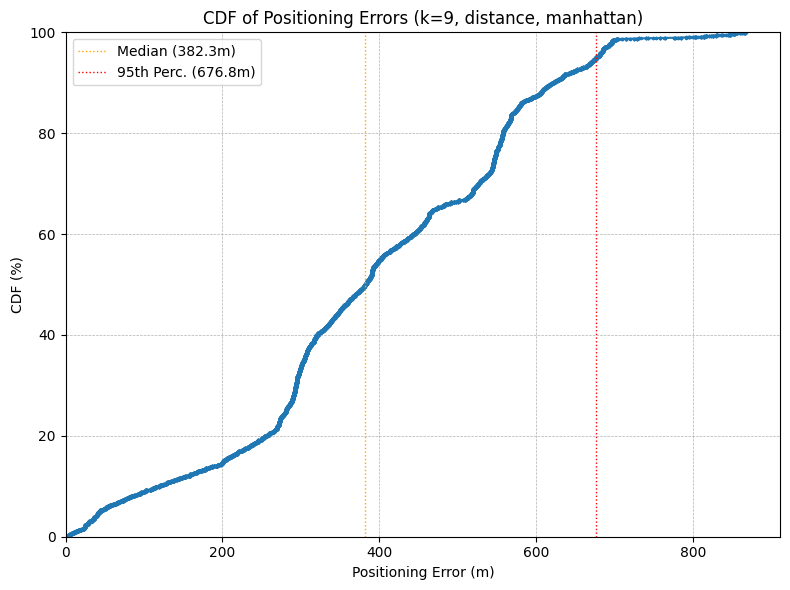

Script finished.


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import geopy.distance
import os
import time
import matplotlib.pyplot as plt # Import matplotlib at the top

# --- User Configuration ---

# File Paths
RAW_DATA_FILE = 'dataset/5GDL.csv'
RESULTS_DIR = 'result' # Define results directory
PROCESSED_DATA_FILE = os.path.join(RESULTS_DIR, 'processed_fingerprints_ext.csv')

# Define the known unique PCIs based on your analysis/list
UNIQUE_PCIS = sorted([3, 13, 23, 30, 40, 48, 59, 68, 76]) # <-- !!! VERIFY this list is complete

# Default Values for Missing Signals/Data
NO_SIGNAL_RSRP_DBM = -155.0  # Use a value clearly below minimum expected measurements
NO_SIGNAL_RSRQ_DB = -40.0   # Use a value clearly below minimum expected measurements
DEFAULT_SINR_DB = -19   # Reasonable default for low/missing SINR
DEFAULT_TA = 0            # Default Timing Advance

# --- Fingerprint Features ---
FEATURE_COLS_RSRP = [f'RSRP_PCI{pci}' for pci in UNIQUE_PCIS]
FEATURE_COLS_RSRQ = [f'RSRQ_PCI{pci}' for pci in UNIQUE_PCIS]
FEATURE_COLS_OTHER = ['SINR_Serving', 'TA_Serving']
ALL_FEATURE_COLS = FEATURE_COLS_RSRP + FEATURE_COLS_RSRQ + FEATURE_COLS_OTHER
LABEL_COLS = ['Latitude', 'Longitude']

# --- Model & Tuning Configuration ---
USE_SCALING = True       # Recommended: Set to True to enable StandardScaler
REPROCESS_DATA = False   # Set to True if raw data changed or first run
USE_GRID_SEARCH = False   # Set to True to find optimal params, False to use predefined below

# Predefined KNN Parameters (used if USE_GRID_SEARCH is False)
DEFAULT_K_NEIGHBORS = 9      # Example: Use the best K found previously
DEFAULT_KNN_WEIGHTS = 'distance' # Example: Use the best weight found previously
DEFAULT_KNN_METRIC = 'manhattan' # Example: Use the best metric found previously

# GridSearchCV Parameters (used if USE_GRID_SEARCH is True)
GRIDSEARCH_CV_FOLDS = 5 # Number of cross-validation folds
GRIDSEARCH_PARAM_GRID = {
    'n_neighbors': list(range(3, 16, 2)), # Example: Try odd k from 3 to 15
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# --- Ensure Results Directory Exists ---
os.makedirs(RESULTS_DIR, exist_ok=True)

# --- Functions ---

def process_raw_data(df_raw, unique_pcis, no_signal_rsrp, no_signal_rsrq, default_sinr, default_ta):
    """Processes the raw UE data into a structured fingerprint DataFrame."""
    print("Processing raw data into fingerprints (including RSRQ, SINR)...")
    start_time = time.time()
    processed_data = []

    # --- Verify these column names match your CSV ---
    SERVING_PCI_COL = 'NR_UE_PCI_0'
    SERVING_RSRP_COL = 'NR_UE_RSRP_0'
    SERVING_RSRQ_COL = 'NR_UE_RSRQ_0'
    SERVING_SINR_COL = 'NR_UE_SINR_0'
    SERVING_TA_COL = 'NR_UE_Timing_Advance'
    NEIGHBOR_PCI_COLS = [f'NR_UE_Nbr_PCI_{i}' for i in range(5)] # Assuming max 5 neighbors
    NEIGHBOR_RSRP_COLS = [f'NR_UE_Nbr_RSRP_{i}' for i in range(5)]
    NEIGHBOR_RSRQ_COLS = [f'NR_UE_Nbr_RSRQ_{i}' for i in range(5)]
    # ---

    # Check for essential columns needed for processing
    essential_cols = LABEL_COLS + [SERVING_PCI_COL, SERVING_RSRP_COL, SERVING_TA_COL]
    # Add optional columns if they exist for checking
    optional_cols = [SERVING_RSRQ_COL, SERVING_SINR_COL] + NEIGHBOR_PCI_COLS + NEIGHBOR_RSRP_COLS + NEIGHBOR_RSRQ_COLS
    expected_cols = essential_cols + [col for col in optional_cols if col in df_raw.columns]

    missing_essential = [col for col in essential_cols if col not in df_raw.columns]
    if missing_essential:
        print(f"FATAL ERROR: Essential columns missing from raw data: {missing_essential}")
        return None # Indicate failure

    print(f"Found columns: {df_raw.columns.tolist()}") # Debugging info

    row_count = len(df_raw)
    print_interval = max(1, row_count // 10) # Print progress roughly 10 times

    for index, row in df_raw.iterrows():
        # Initialize fingerprint with default values
        fingerprint = {f'RSRP_PCI{pci}': no_signal_rsrp for pci in unique_pcis}
        fingerprint.update({f'RSRQ_PCI{pci}': no_signal_rsrq for pci in unique_pcis})
        fingerprint['TA_Serving'] = default_ta
        fingerprint['SINR_Serving'] = default_sinr
        fingerprint['Latitude'] = row['Latitude']
        fingerprint['Longitude'] = row['Longitude']

        # --- Serving Cell ---
        try:
            serving_pci_val = row.get(SERVING_PCI_COL) # No default needed, checked earlier
            serving_rsrp_val = row.get(SERVING_RSRP_COL)
            serving_rsrq_val = row.get(SERVING_RSRQ_COL) # Optional
            serving_sinr_val = row.get(SERVING_SINR_COL) # Optional

            if pd.notna(serving_pci_val):
                serving_pci = int(serving_pci_val)
                if serving_pci in unique_pcis:
                    if pd.notna(serving_rsrp_val):
                        fingerprint[f'RSRP_PCI{serving_pci}'] = float(serving_rsrp_val)
                    if pd.notna(serving_rsrq_val):
                        fingerprint[f'RSRQ_PCI{serving_pci}'] = float(serving_rsrq_val)

            if pd.notna(serving_sinr_val):
                 fingerprint['SINR_Serving'] = float(serving_sinr_val)

        except (ValueError, TypeError) as e:
             # Log specific error for debugging potential data issues
             # print(f"Warning: Data conversion error in serving cell processing at index {index}: {e}")
             pass # Continue processing other parts

        # --- Neighbor Cells ---
        for i in range(len(NEIGHBOR_PCI_COLS)): # Iterate based on defined neighbor cols
             try:
                 # Check if neighbor columns exist for this index i before accessing
                 nbr_pci_col = NEIGHBOR_PCI_COLS[i]
                 nbr_rsrp_col = NEIGHBOR_RSRP_COLS[i]
                 nbr_rsrq_col = NEIGHBOR_RSRQ_COLS[i]

                 if nbr_pci_col in row: # Check existence
                    nbr_pci_val = row.get(nbr_pci_col)
                    nbr_rsrp_val = row.get(nbr_rsrp_col) if nbr_rsrp_col in row else None
                    nbr_rsrq_val = row.get(nbr_rsrq_col) if nbr_rsrq_col in row else None

                    if pd.notna(nbr_pci_val):
                        nbr_pci = int(nbr_pci_val)
                        if nbr_pci in unique_pcis:
                            if pd.notna(nbr_rsrp_val):
                                fingerprint[f'RSRP_PCI{nbr_pci}'] = float(nbr_rsrp_val)
                            if pd.notna(nbr_rsrq_val):
                                fingerprint[f'RSRQ_PCI{nbr_pci}'] = float(nbr_rsrq_val)

             except (ValueError, TypeError) as e:
                 # Log specific error
                 print(f"Warning: Data conversion error in neighbor cell {i} processing at index {index}: {e}")
                 pass # Continue processing

        # --- Timing Advance ---
        try:
            ta_val = row.get(SERVING_TA_COL) # Checked earlier
            if pd.notna(ta_val):
                fingerprint['TA_Serving'] = float(ta_val)
        except (ValueError, TypeError) as e:
            # Log specific error
            print(f"Warning: Data conversion error in TA processing at index {index}: {e}")
            pass # Keep default TA

        processed_data.append(fingerprint)

        if (index + 1) % print_interval == 0 or (index + 1) == row_count:
            print(f"  Processed {index + 1}/{row_count} rows...")

    elapsed_time = time.time() - start_time
    print(f"Data processing finished in {elapsed_time:.2f} seconds.")
    return pd.DataFrame(processed_data)

def calculate_errors(y_true_df, y_pred_array):
    """Calculates positioning errors and returns errors list and details DataFrame."""
    print("Calculating positioning errors...")
    errors = []
    error_details = []
    invalid_preds = 0

    if len(y_true_df) != len(y_pred_array):
        print("Error: Mismatch between number of true labels and predictions.")
        return np.array([]), pd.DataFrame()

    for i in range(len(y_true_df)):
        true_lat = y_true_df.iloc[i]['Latitude']
        true_lon = y_true_df.iloc[i]['Longitude']
        pred_lat = y_pred_array[i][0]
        pred_lon = y_pred_array[i][1]

        # Basic check for valid coordinate ranges
        if -90 <= pred_lat <= 90 and -180 <= pred_lon <= 180:
            try:
                # Use geodesic distance (more accurate for geographic coords)
                distance = geopy.distance.geodesic((true_lat, true_lon), (pred_lat, pred_lon)).meters
                errors.append(distance)
                error_details.append({
                    'true_lat': true_lat,
                    'true_lon': true_lon,
                    'pred_lat': pred_lat,
                    'pred_lon': pred_lon,
                    'error_m': distance
                })
            except ValueError as e:
                print(f"Warning: geopy error for point {i} (True: {true_lat},{true_lon}, Pred: {pred_lat},{pred_lon}): {e}. Skipping.")
                invalid_preds += 1
        else:
            print(f"Warning: Invalid predicted coordinates ({pred_lat:.4f}, {pred_lon:.4f}) for test point {i}. Skipping.")
            error_details.append({
                'true_lat': true_lat,
                'true_lon': true_lon,
                'pred_lat': pred_lat, # Store invalid prediction
                'pred_lon': pred_lon,
                'error_m': np.nan # Mark error as NaN
            })
            invalid_preds += 1

    print(f"Finished calculating errors. Skipped {invalid_preds} invalid predictions.")
    return np.array(errors), pd.DataFrame(error_details)


# --- Main Script ---

# 1. Load and Process Data
processed_df = None
if REPROCESS_DATA or not os.path.exists(PROCESSED_DATA_FILE):
    try:
        print(f"Loading raw data from {RAW_DATA_FILE}...")
        df_raw = pd.read_csv(RAW_DATA_FILE)
        print(f"Raw data loaded: {df_raw.shape[0]} rows, {df_raw.shape[1]} columns.")

        # --- Initial Cleaning ---
        # Drop rows with missing essential coordinates BEFORE processing
        initial_rows = len(df_raw)
        df_raw = df_raw.dropna(subset=LABEL_COLS)
        if len(df_raw) < initial_rows:
            print(f"Dropped {initial_rows - len(df_raw)} rows with missing Lat/Lon.")

        if df_raw.empty:
             print("Error: No valid rows remaining after dropping missing Lat/Lon.")
             exit()

        # Process data
        processed_df = process_raw_data(df_raw, UNIQUE_PCIS,
                                          NO_SIGNAL_RSRP_DBM,
                                          NO_SIGNAL_RSRQ_DB,
                                          DEFAULT_SINR_DB,
                                          DEFAULT_TA)
        if processed_df is None or processed_df.empty:
             print("Error: Data processing failed or resulted in an empty DataFrame.")
             exit()

        print(f"Saving processed data ({len(processed_df)} fingerprints) to {PROCESSED_DATA_FILE}...")
        processed_df.to_csv(PROCESSED_DATA_FILE, index=False)
        print("Processed data saved.")

    except FileNotFoundError:
        print(f"FATAL ERROR: Raw data file not found at {RAW_DATA_FILE}")
        exit()
    except Exception as e:
        print(f"FATAL ERROR during data loading/processing: {e}")
        import traceback
        traceback.print_exc() # Print detailed traceback for debugging
        exit()
else:
    print(f"Loading pre-processed data from {PROCESSED_DATA_FILE}...")
    try:
        processed_df = pd.read_csv(PROCESSED_DATA_FILE)
        print(f"Pre-processed data loaded: {len(processed_df)} fingerprints.")
    except FileNotFoundError:
        print(f"FATAL ERROR: Processed data file not found at {PROCESSED_DATA_FILE}. Set REPROCESS_DATA=True.")
        exit()
    except Exception as e:
        print(f"FATAL ERROR loading processed data: {e}")
        exit()

# Final check on loaded data
if processed_df is None or processed_df.empty:
    print("FATAL ERROR: No data available for modeling.")
    exit()

# 2. Prepare Features (X) and Labels (y)
print("Preparing features (X) and labels (y)...")
try:
    X = processed_df[ALL_FEATURE_COLS]
    y = processed_df[LABEL_COLS]
except KeyError as e:
    print(f"FATAL ERROR: Missing expected feature/label columns in processed data: {e}")
    print(f"Available columns: {processed_df.columns.tolist()}")
    exit()

# Check for potential issues: rows containing only default feature values
# Updated Check: Checks RSRP and RSRQ defaults specifically
rsrp_defaults = (X[FEATURE_COLS_RSRP] == NO_SIGNAL_RSRP_DBM).all(axis=1)
rsrq_defaults = (X[FEATURE_COLS_RSRQ] == NO_SIGNAL_RSRQ_DB).all(axis=1)
other_defaults = True
if 'SINR_Serving' in X:
    other_defaults &= (X['SINR_Serving'] == DEFAULT_SINR_DB)
if 'TA_Serving' in X:
    other_defaults &= (X['TA_Serving'] == DEFAULT_TA)

if (rsrp_defaults & rsrq_defaults & other_defaults).any():
     print("Warning: Some rows seem to contain only default feature values across all signal types.")


# 3. Split Data into Training and Test Sets
print("Splitting data into training and test sets (70/30 split)...")
if len(X) < 2: # Need at least 2 samples for split
    print("FATAL ERROR: Not enough data samples to create train/test splits.")
    exit()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"  Training set size: {len(X_train)} samples ({X_train.shape[1]} features)")
print(f"  Test set size: {len(X_test)} samples")

if len(X_train) == 0 or len(X_test) == 0:
    print("FATAL ERROR: Train or test split resulted in zero samples.")
    exit()

# 4. Feature Scaling (Conditional)
scaler = None # Initialize scaler variable
X_train_knn = X_train.values # Default to numpy array
X_test_knn = X_test.values   # Default to numpy array
if USE_SCALING:
    print("Applying StandardScaler to features...")
    scaler = StandardScaler()
    X_train_knn = scaler.fit_transform(X_train) # Fit AND transform training data
    X_test_knn = scaler.transform(X_test)       # Transform test data using learned parameters
    print("Scaling complete.")
else:
    print("Feature scaling is disabled.")


# 5. Model Training (Conditional: GridSearchCV or Manual)
knn_model = None
best_params = {}

if USE_GRID_SEARCH:
    print("\n--- Hyperparameter Tuning with GridSearchCV ---")
    start_time_grid = time.time()

    # Create a base KNN Regressor instance
    knn_base = KNeighborsRegressor(n_jobs=-1) # Use all available CPU cores

    # Set up GridSearchCV
    print(f"Searching parameter grid: {GRIDSEARCH_PARAM_GRID}")
    print(f"Using {GRIDSEARCH_CV_FOLDS}-fold cross-validation.")
    grid_search = GridSearchCV(knn_base, GRIDSEARCH_PARAM_GRID, cv=GRIDSEARCH_CV_FOLDS,
                               scoring='neg_mean_squared_error', # Lower error = better
                               refit=True, # Automatically retrains best model on full train set
                               verbose=1) # Shows progress

    # Fit GridSearchCV on the TRAINING data (scaled if USE_SCALING is True)
    grid_search.fit(X_train_knn, y_train)

    elapsed_time_grid = time.time() - start_time_grid
    print(f"GridSearchCV finished in {elapsed_time_grid:.2f} seconds.")

    # Get the best model and its parameters
    knn_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best parameters found: {best_params}")
    print(f"Best cross-validation score (Negative MSE): {grid_search.best_score_:.4f}")
    print("--- End of GridSearchCV ---")

else:
    print("\n--- Training with Predefined Parameters ---")
    start_time_train = time.time()
    # Use the default parameters defined at the top
    best_params = {
        'n_neighbors': DEFAULT_K_NEIGHBORS,
        'weights': DEFAULT_KNN_WEIGHTS,
        'metric': DEFAULT_KNN_METRIC
    }
    print(f"Using parameters: k={best_params['n_neighbors']}, weights='{best_params['weights']}', metric='{best_params['metric']}'")

    knn_model = KNeighborsRegressor(n_neighbors=best_params['n_neighbors'],
                                  weights=best_params['weights'],
                                  metric=best_params['metric'],
                                  n_jobs=-1)

    # Train the model
    knn_model.fit(X_train_knn, y_train)
    elapsed_time_train = time.time() - start_time_train
    print(f"Manual k-NN training finished in {elapsed_time_train:.2f} seconds.")
    print("--- End of Manual Training ---")


# --- Define Final Output Filename ---
final_k = best_params.get('n_neighbors', 'UnknownK')
ERROR_OUTPUT_FILE = os.path.join(RESULTS_DIR, f'{final_k}nn_pos_errors_{best_params.get("weights","")}_{best_params.get("metric","")}UL.csv')
PLOT_OUTPUT_FILE = ERROR_OUTPUT_FILE.replace('.csv', '_cdf.png')


# 6. Predict on Test Set
print("\nPredicting locations for the test set...")
start_time_pred = time.time()
if knn_model is None:
     print("FATAL ERROR: KNN model was not trained.")
     exit()

y_pred = knn_model.predict(X_test_knn) # Use scaled test data if scaling was applied

elapsed_time_pred = time.time() - start_time_pred
print(f"Prediction finished in {elapsed_time_pred:.2f} seconds.")


# 7. Calculate Errors and Save Details
valid_errors, error_details_df = calculate_errors(y_test, y_pred)

if not error_details_df.empty:
    print(f"\nSaving detailed error results to {ERROR_OUTPUT_FILE}...")
    try:
        error_details_df.to_csv(ERROR_OUTPUT_FILE, index=False, float_format='%.6f')
        print("Error details saved successfully.")
    except Exception as e:
        print(f"Error saving error details CSV: {e}")
else:
    print("\nNo error details to save.")


# 8. Report Aggregate Performance Metrics
if len(valid_errors) > 0:
    mean_error = np.mean(valid_errors)
    median_error = np.median(valid_errors)
    std_dev_error = np.std(valid_errors)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # Note: This RMSE is on lat/lon, not distance error directly
    rmse_dist = np.sqrt(np.mean(np.square(valid_errors))) # RMSE on distance errors

    print("\n--- Positioning Performance ---")
    print(f"Model Parameters: k={best_params['n_neighbors']}, weights='{best_params['weights']}', metric='{best_params['metric']}'")
    print(f"Number of Test Points Evaluated: {len(valid_errors)} (out of {len(y_test)})")
    print(f"Mean Error:      {mean_error:.2f} m")
    print(f"Median Error:    {median_error:.2f} m (50th Percentile)")
    print(f"Std Deviation:   {std_dev_error:.2f} m")
    print(f"RMSE (distance): {rmse_dist:.2f} m")

    # Calculate Percentiles (CDF points)
    percentiles_to_calc = [ 20, 40, 68, 80, 90, 95]
    percentile_values = np.percentile(valid_errors, percentiles_to_calc)
    print("\nError Percentiles (CDF):")
    for p, v in zip(percentiles_to_calc, percentile_values):
        print(f"  {p}th Percentile:  {v:.2f} m")
    print("-----------------------------\n")

    # Generate and Save CDF Plot
    print(f"Generating CDF plot...")
    try:
        sorted_errors = np.sort(valid_errors)
        cdf = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
        plt.figure(figsize=(8, 6)) # Slightly larger figure
        plt.plot(sorted_errors, cdf * 100, marker='.', linestyle='-', markersize=3)
        plt.xlabel("Positioning Error (m)")
        plt.ylabel("CDF (%)")
        plt.title(f"CDF of Positioning Errors (k={best_params['n_neighbors']}, {best_params['weights']}, {best_params['metric']})")
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.ylim(0, 100)
        plt.xlim(left=0) # Start x-axis at 0
        # Add median and 95th percentile lines for reference
        plt.axvline(median_error, color='orange', linestyle=':', linewidth=1, label=f'Median ({median_error:.1f}m)')
        p95_val = np.percentile(valid_errors, 95)
        plt.axvline(p95_val, color='red', linestyle=':', linewidth=1, label=f'95th Perc. ({p95_val:.1f}m)')
        plt.legend()
        plt.tight_layout() # Adjust layout
        plt.savefig(PLOT_OUTPUT_FILE)
        print(f"CDF plot saved to {PLOT_OUTPUT_FILE}")
        plt.show() # Show the plot interactively
    except Exception as e:
        print(f"Error generating or saving plot: {e}")

else:
    print("\n--- Positioning Performance ---")
    print("No valid error measurements were calculated. Cannot report performance metrics.")
    print("-----------------------------\n")

print("Script finished.")

Loading pre-processed data from result\processed_fingerprints_ext.csv...
Pre-processed data loaded: 72478 fingerprints.
Preparing features (X) and labels (y)...
Splitting data into training and test sets (70/30 split)...
  Training set size: 50734 samples (20 features)
  Test set size: 21744 samples
Applying StandardScaler to features...
Scaling complete.

--- Hyperparameter Tuning with GridSearchCV ---
Searching parameter grid: {'n_neighbors': [3, 5, 7, 9, 11, 13, 15], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
Using 5-fold cross-validation.
Fitting 5 folds for each of 28 candidates, totalling 140 fits
c:\Users\deeric\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\deeric\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\deeric\miniconda3\Lib\subprocess.py", line 550, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\deeric\miniconda3\Lib\subprocess.py", line 1028, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\deeric\miniconda3\Lib\subprocess.py", line 1540, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
GridSearchCV finished in 120.10 seconds.
Best parameters found: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Best cross-validation score (Negative MSE): -0.0000
--- End of GridSearchCV ---

Predicting locations for the test set...
Prediction finished in 2.06 seconds.
Calculating positioning errors...
Finished calculating errors. Skipped 0 invalid predictions.

Saving detailed error results to result\9nn_pos_errors_distance_manhattanUL.csv...
Error details saved successfully.

--- Positioning Performance ---
Model Parameters: k=9, weights='distance', metric='manhattan'
Number of Test Points Evaluated: 21744 (out of 21744)
Mean Error:      388.89 m
Median Error:    382.27 m (50th Percentile)
Std Deviation:   184.11 m
RMSE (distance): 430.27 m

Error Percentiles (CDF):
  68th Percentile:  517.84 m
  80th Percentile:  557.92 m
  90th Percentile:  621.14 m
  95th Percentile:  676.82 m
-----------------------------

Generating CDF plot...
CDF plot saved to result\9nn_pos_errors_distance_manhattanUL_cdf.png
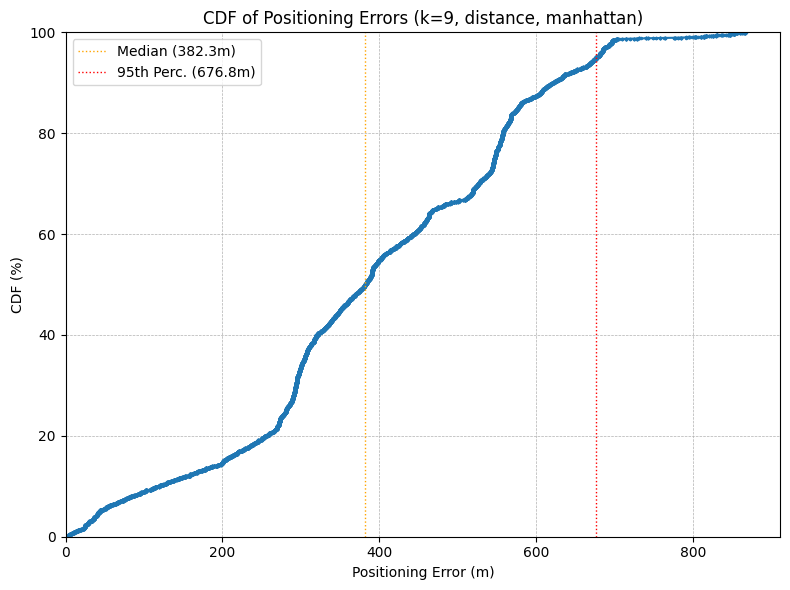

In [4]:
import pandas as pd
import numpy as np

def process_ue_dataset(input_csv_path, output_csv_path, no_signal_value=-140):
    """
    Process UE dataset to create a fingerprinting dataset with fixed-length feature vectors.
    
    Args:
        input_csv_path: Path to the input CSV file
        output_csv_path: Path to save the processed CSV file
        no_signal_value: Value to use for PCIs not detected at a measurement point
    """
    # Load the UE dataset
    print(f"Loading dataset from {input_csv_path}...")
    df = pd.read_csv(input_csv_path)
    
    # Find all unique PCIs (serving and neighbor)
    unique_pcis = set()
    
    # Add serving PCI
    if 'NR_UE_PCI_0' in df.columns:
        unique_pcis.update(df['NR_UE_PCI_0'].dropna().unique())
        print(df['NR_UE_PCI_0'].dropna().unique())
    
    # Add neighbor PCIs
    for i in range(5):  # 0 to 4 for neighbor slots
        col_name = f'NR_UE_Nbr_PCI_{i}'
        if col_name in df.columns:
            unique_pcis.update(df[col_name].dropna().unique())
            print(df[col_name].dropna().unique())
    
    # Convert to sorted list and remove any non-numeric values
    unique_pcis = sorted([pci for pci in unique_pcis if pd.notna(pci) and str(pci).isdigit()])
    print(f"Found {len(unique_pcis)} unique PCIs: {unique_pcis}")
    
    # Create new DataFrame with Latitude and Longitude
    new_df = df[['Latitude', 'Longitude']].copy()
    
    # Add TA_Serving column
    if 'NR_UE_Timing_Advance' in df.columns:
        new_df['TA_Serving'] = df['NR_UE_Timing_Advance']
    else:
        print("Warning: NR_UE_Timing_Advance column not found in the dataset")
        new_df['TA_Serving'] = None
    
    # Create columns for each unique PCI
    for pci in unique_pcis:
        col_name = f'RSRP_PCI{pci}'
        new_df[col_name] = no_signal_value
    
    # Iterate through each row and fill in the RSRP values
    print("Processing rows...")
    for idx, row in df.iterrows():
        # Process serving cell
        if 'NR_UE_PCI_0' in df.columns and 'NR_UE_RSRP_0' in df.columns:
            serving_pci = row['NR_UE_PCI_0']
            if pd.notna(serving_pci) and str(serving_pci).isdigit() and serving_pci in unique_pcis:
                col_name = f'RSRP_PCI{serving_pci}'
                new_df.at[idx, col_name] = row['NR_UE_RSRP_0']
        
        # Process neighbor cells
        for i in range(5):  # 0 to 4 for neighbor slots
            nbr_pci_col = f'NR_UE_Nbr_PCI_{i}'
            nbr_rsrp_col = f'NR_UE_Nbr_RSRP_{i}'
            
            if nbr_pci_col in df.columns and nbr_rsrp_col in df.columns:
                nbr_pci = row[nbr_pci_col]
                if pd.notna(nbr_pci) and str(nbr_pci).isdigit() and nbr_pci in unique_pcis:
                    col_name = f'RSRP_PCI{nbr_pci}'
                    new_df.at[idx, col_name] = row[nbr_rsrp_col]
    
    # Save the processed data
    print(f"Saving processed dataset to {output_csv_path}...")
    new_df.to_csv(output_csv_path, index=False)
    print("Processing complete!")
    
    return new_df

# Example usage
# Sample PCIs as mentioned in your request
print("Expected PCIs from description: PCI30, PCI40, PCI59, PCI48, PCI68, PCI76, PCI3, PCI13, PCI23")

# Replace with your actual file paths
input_file = "dataset/5GDL.csv"
output_file = "result/fingerprinting_dataset.csv"

# Process the dataset
result_df = process_ue_dataset(input_file, output_file)

# Display a sample of the processed data
print("\nSample of processed data:")
print(result_df.head())

# Display statistics
print("\nDataset statistics:")
print(f"Number of measurement points: {len(result_df)}")
print(f"Number of features: {len(result_df.columns)}")

# List all RSRP columns to verify
rsrp_columns = [col for col in result_df.columns if col.startswith('RSRP_PCI')]
print(f"RSRP columns created: {rsrp_columns}")

Expected PCIs from description: PCI30, PCI40, PCI59, PCI48, PCI68, PCI76, PCI3, PCI13, PCI23
Loading dataset from dataset/5GDL.csv...


C:\Users\deeric\AppData\Local\Temp\ipykernel_10892\2916776885.py:15: DtypeWarning: Columns (1,4,30,32,33,35,45,53,54,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_csv_path)


[ 48.  76.  68.   3.  13.  23.  40.  30.  59. 278.  38.]
[ 76.  59.  48.  68.   3.  23.  13.  40.  30. 278.  38.]
[ 76.  13.  23.  68.  59.  40.  48.  30.  38. 278.]
[ 23.  76.  68.  40.  30.  59. 278.]
[76. 68. 59.]
[76.]
Found 0 unique PCIs: []
Processing rows...
Saving processed dataset to result/fingerprinting_dataset.csv...
Processing complete!

Sample of processed data:
   Latitude  Longitude  TA_Serving
0       NaN        NaN         NaN
1       NaN        NaN         NaN
2  41.10723   29.02949         NaN
3  41.10723   29.02949         NaN
4  41.10723   29.02949         NaN

Dataset statistics:
Number of measurement points: 690188
Number of features: 3
RSRP columns created: []
